***

### Contents
[Environment Setup](#environment)

[Data Preparation](#preparation)

Competition Data

Match Data

Events Data

[Analysis: Competitions & Seasons](#analysis_comp)

Competitions & Seasons

Gender

Home-Away


[Analysis: Teams, Lineup & Manager](#analysis_team)

[Analysis: Events](#analysis_events)

Events frequency per match

Event types

[Attempting a Predictive Model](#predictive_model)

Feature selection

Model build & evaluation

[Conclusion](#conclusion)


<a id='environment'></a>
# Environment Setup

In [1]:
### Setting environment
import glob
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix


### Allow multi-line results
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### See all dataframe output
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
### Identifying all files in directory
path = r'open-data-master/data/**'
listing = glob.glob(path, recursive=True)

### Listing the files
filelist = pd.DataFrame()
filelist['filename'] = [f for f in listing if '.' in f] 
filelist['format'] = filelist.apply(lambda x: x['filename'].rsplit(".",1)[1], axis=1)

### Check number of files and file types
print(len(filelist), "files found.")
filelist.groupby(['format']).count()


1818 files found.


,filename
format,
json,1818


<a id='preparation'></a>
# Data Preparation
### Competition Data

In [3]:
### Loading Competitions data (single file)
competitions = filelist[filelist['filename'].str.contains("competition")]
comp = pd.read_json(competitions['filename'].iloc[0])
comp


,competition_id,season_id,country_name,competition_name,competition_gender,season_name,match_updated,match_available
0,16,4,Europe,Champions League,male,2018/2019,2020-07-29T05:00,2020-07-29T05:00
1,16,1,Europe,Champions League,male,2017/2018,2020-07-29T05:00,2020-07-29T05:00
2,16,2,Europe,Champions League,male,2016/2017,2020-08-26T12:33:15.869622,2020-07-29T05:00
3,16,27,Europe,Champions League,male,2015/2016,2020-08-26T12:33:15.869622,2020-07-29T05:00
4,16,26,Europe,Champions League,male,2014/2015,2020-08-26T12:33:15.869622,2020-07-29T05:00
5,16,25,Europe,Champions League,male,2013/2014,2020-08-26T12:33:15.869622,2020-07-29T05:00
6,16,24,Europe,Champions League,male,2012/2013,2020-08-26T12:33:15.869622,2020-07-29T05:00
7,16,23,Europe,Champions League,male,2011/2012,2020-08-26T12:33:15.869622,2020-07-29T05:00
8,16,22,Europe,Champions League,male,2010/2011,2020-07-29T05:00,2020-07-29T05:00
9,16,21,Europe,Champions League,male,2009/2010,2020-07-29T05:00,2020-07-29T05:00


### Match Data

In [4]:
### Preparation of match data
matchlist = filelist[filelist['filename'].str.contains('matches')]

matches = pd.DataFrame()
for m in matchlist['filename']: 
    ma = pd.DataFrame()
    ma = pd.read_json(m, dtype = {"match_id": str})
    ma['competition_id'], ma['season_id'] = (m.split("/")[3],m.split("/")[4].split(".")[0])
    matches = matches.append(ma,ignore_index=True)
matches

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,last_updated,metadata,match_week,competition_stage,stadium,referee,competition_id,season_id
0,69225,2008-12-13,22:00:00.000,"{'competition_id': 11, 'country_name': 'Spain'...","{'season_id': 41, 'season_name': '2008/2009'}","{'home_team_id': 217, 'home_team_name': 'Barce...","{'away_team_id': 220, 'away_team_name': 'Real ...",2.0,0.0,available,2020-07-29T05:00,"{'data_version': '1.1.0', 'shot_fidelity_versi...",15.0,"{'id': 1, 'name': 'Regular Season'}","{'id': 342, 'name': 'Camp Nou', 'country': {'i...","{'id': 1011, 'name': 'Luis Medina Cantalejo'}",11,41
1,69212,2008-10-04,22:00:00.000,"{'competition_id': 11, 'country_name': 'Spain'...","{'season_id': 41, 'season_name': '2008/2009'}","{'home_team_id': 217, 'home_team_name': 'Barce...","{'away_team_id': 212, 'away_team_name': 'Atlét...",6.0,1.0,available,2020-07-29T05:00,"{'data_version': '1.1.0', 'shot_fidelity_versi...",6.0,"{'id': 1, 'name': 'Regular Season'}","{'id': 342, 'name': 'Camp Nou', 'country': {'i...","{'id': 1070, 'name': 'Iturralde '}",11,41
2,69235,2008-11-01,20:00:00.000,"{'competition_id': 11, 'country_name': 'Spain'...","{'season_id': 41, 'season_name': '2008/2009'}","{'home_team_id': 223, 'home_team_name': 'Málag...","{'away_team_id': 217, 'away_team_name': 'Barce...",1.0,4.0,available,2020-07-29T05:00,"{'data_version': '1.1.0', 'shot_fidelity_versi...",9.0,"{'id': 1, 'name': 'Regular Season'}","{'id': 346, 'name': 'Estadio La Rosaleda', 'co...","{'id': 407, 'name': 'Carlos Velasco Carballo',...",11,41
3,69232,2008-10-25,22:00:00.000,"{'competition_id': 11, 'country_name': 'Spain'...","{'season_id': 41, 'season_name': '2008/2009'}","{'home_team_id': 217, 'home_team_name': 'Barce...","{'away_team_id': 403, 'away_team_name': 'Almer...",5.0,0.0,available,2020-07-29T05:00,"{'data_version': '1.1.0', 'shot_fidelity_versi...",8.0,"{'id': 1, 'name': 'Regular Season'}","{'id': 342, 'name': 'Camp Nou', 'country': {'i...","{'id': 1007, 'name': 'Alfonso Perez Burrull'}",11,41
4,69216,2009-03-07,20:00:00.000,"{'competition_id': 11, 'country_name': 'Spain'...","{'season_id': 41, 'season_name': '2008/2009'}","{'home_team_id': 217, 'home_team_name': 'Barce...","{'away_team_id': 215, 'away_team_name': 'Athle...",2.0,0.0,available,2020-07-29T05:00,"{'data_version': '1.1.0', 'shot_fidelity_versi...",26.0,"{'id': 1, 'name': 'Regular Season'}","{'id': 342, 'name': 'Camp Nou', 'country': {'i...","{'id': 221, 'name': 'Alberto Undiano', 'countr...",11,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,3749278,2003-12-20,16:00:00.000,"{'competition_id': 2, 'country_name': 'England...","{'season_id': 44, 'season_name': '2003/2004'}","{'home_team_id': 328, 'home_team_name': 'Bolto...","{'away_team_id': 1, 'away_team_name': 'Arsenal...",1.0,1.0,available,2020-08-30T07:13:01.092744,"{'data_version': '1.1.0', 'shot_fidelity_versi...",1.0,"{'id': 1, 'name': 'Regular Season'}",NaN,"{'id': 1279, 'name': 'None'}",2,44
874,3749526,2003-10-26,15:00:00.000,"{'competition_id': 2, 'country_name': 'England...","{'season_id': 44, 'season_name': '2003/2004'}","{'home_team_id': 75, 'home_team_name': 'Charlt...","{'away_team_id': 1, 'away_team_name': 'Arsenal...",1.0,1.0,available,2020-07-29T05:00,"{'data_version': '1.1.0', 'shot_fidelity_versi...",10.0,"{'id': 1, 'name': 'Regular Season'}",NaN,"{'id': 1279, 'name': 'None'}",2,44
875,3749052,2004-02-07,16:00:00.000,"{'competition_id': 2, 'country_name': 'England...","{'season_id': 44, 'season_name': '2003/2004'}","{'home_team_id': 46, 'home_team_name': 'Wolver...","{'away_team_id': 1, 'away_team_name': 'Arsenal...",1.0,3.0,available,2020-07-29T05:00,"{'data_version': '1.1.0', 'shot_fidelity_versi...",24.0,"{'id': 1, 'name': 'Regular Season'}",NaN,"{'id': 1279, 'name': 'None'}",2,44
876,3749603,2004-05-09,17:05:00.000,"{'competition_id': 2, 'country_name': 'England...","{'season_id': 44, 'season_name': '2003/2004'}"

In [5]:
### Function to extract values from nested JSON objects
def extract (dfcol,key):
    if isinstance(dfcol,dict):
        return dfcol.get(key)
    

In [6]:
### Function to identify which team won the match
def win(df):
    if df['home_score']>df['away_score']:
        result = 'home'
        winteam = df['home_team_id']
    elif df['home_score']<df['away_score']:
        result = 'away'
        winteam = df['away_team_id']
    elif df['home_score']==df['away_score']:
        result = 'draw'
        winteam = 0
    else:
        result = 'err'
        winteam = 'err'
    return result, winteam

In [7]:
### Expansion of match data
matches['home_team_id'] = matches.apply(lambda x: extract(x['home_team'],'home_team_id'), axis=1)
matches['away_team_id'] = matches.apply(lambda x: extract(x['away_team'],'away_team_id'), axis=1)
matches['competition_stage_id'] = matches.apply(lambda x: extract(x['competition_stage'],'id'), axis=1)
matches['competition_name'] = matches.apply(lambda x: extract(x['competition'],'competition_name'), axis=1)
matches['season_name'] = matches.apply(lambda x: extract(x['season'],'season_name'), axis=1)
matches['stadium_id'] = matches.apply(lambda x: extract(x['stadium'],'id'), axis=1)
matches['referee_id'] = matches.apply(lambda x: extract(x['referee'],'id'), axis=1)
matches['match_gender'] = matches.apply(lambda x: extract(x['home_team'],'home_team_gender'), axis=1)
matches[['win','win_team_id']] = matches.apply(lambda x: win(x),axis=1, result_type='expand')
matches

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,last_updated,metadata,match_week,competition_stage,stadium,referee,competition_id,season_id,home_team_id,away_team_id,competition_stage_id,competition_name,season_name,stadium_id,referee_id,match_gender,win,win_team_id
0,69225,2008-12-13,22:00:00.000,"{'competition_id': 11, 'country_name': 'Spain'...","{'season_id': 41, 'season_name': '2008/2009'}","{'home_team_id': 217, 'home_team_name': 'Barce...","{'away_team_id': 220, 'away_team_name': 'Real ...",2.0,0.0,available,2020-07-29T05:00,"{'data_version': '1.1.0', 'shot_fidelity_versi...",15.0,"{'id': 1, 'name': 'Regular Season'}","{'id': 342, 'name': 'Camp Nou', 'country': {'i...","{'id': 1011, 'name': 'Luis Medina Cantalejo'}",11,41,217,220,1,La Liga,2008/2009,342.0,1011.0,male,home,217
1,69212,2008-10-04,22:00:00.000,"{'competition_id': 11, 'country_name': 'Spain'...","{'season_id': 41, 'season_name': '2008/2009'}","{'home_team_id': 217, 'home_team_name': 'Barce...","{'away_team_id': 212, 'away_team_name': 'Atlét...",6.0,1.0,available,2020-07-29T05:00,"{'data_version': '1.1.0', 'shot_fidelity_versi...",6.0,"{'id': 1, 'name': 'Regular Season'}","{'id': 342, 'name': 'Camp Nou', 'country': {'i...","{'id': 1070, 'name': 'Iturralde '}",11,41,217,212,1,La Liga,2008/2009,342.0,1070.0,male,home,217
2,69235,2008-11-01,20:00:00.000,"{'competition_id': 11, 'country_name': 'Spain'...","{'season_id': 41, 'season_name': '2008/2009'}","{'home_team_id': 223, 'home_team_name': 'Málag...","{'away_team_id': 217, 'away_team_name': 'Barce...",1.0,4.0,available,2020-07-29T05:00,"{'data_version': '1.1.0', 'shot_fidelity_versi...",9.0,"{'id': 1, 'name': 'Regular Season'}","{'id': 346, 'name': 'Estadio La Rosaleda', 'co...","{'id': 407, 'name': 'Carlos Velasco Carballo',...",11,41,223,217,1,La Liga,2008/2009,346.0,407.0,male,away,217
3,69232,2008-10-25,22:00:00.000,"{'competition_id': 11, 'country_name': 'Spain'...","{'season_id': 41, 'season_name': '2008/2009'}","{'home_team_id': 217, 'home_team_name': 'Barce...","{'away_team_id': 403, 'away_team_name': 'Almer...",5.0,0.0,available,2020-07-29T05:00,"{'data_version': '1.1.0', 'shot_fidelity_versi...",8.0,"{'id': 1, 'name': 'Regular Season'}","{'id': 342, 'name': 'Camp Nou', 'country': {'i...","{'id': 1007, 'name': 'Alfonso Perez Burrull'}",11,41,217,403,1,La Liga,2008/2009,342.0,1007.0,male,home,217
4,69216,2009-03-07,20:00:00.000,"{'competition_id': 11, 'country_name': 'Spain'...","{'season_id': 41, 'season_name': '2008/2009'}","{'home_team_id': 217, 'home_team_name': 'Barce...","{'away_team_id': 215, 'away_team_name': 'Athle...",2.0,0.0,available,2020-07-29T05:00,"{'data_version': '1.1.0', 'shot_fidelity_versi...",26.0,"{'id': 1, 'name': 'Regular Season'}","{'id': 342, 'name': 'Camp Nou', 'country': {'i...","{'id': 221, 'name': 'Alberto Undiano', 'countr...",11,41,217,215,1,La Liga,2008/2009,342.0,221.0,male,home,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,3749278,2003-12-20,16:00:00.000,"{'competition_id': 2, 'country_name': 'England...","{'season_id': 44, 'season_name': '2003/2004'}","{'home_team_id': 328, 'home_team_name': 'Bolto...","{'away_team_id': 1, 'away_team_name': 'Arsenal...",1.0,1.0,available,2020-08-30T07:13:01.092744,"{'data_version': '1.1.0', 'shot_fidelity_versi...",1.0,"{'id': 1, 'name': 'Regular Season'}",NaN,"{'id': 1279, 'name': 'None'}",2,44,328,1,1,Premier League,2003/2004,NaN,1279.0,male,draw,0
874,3749526,2003-10-26,15:00:00.000,"{'competition_id': 2, 'country_name': 'England...","{'season_id': 44, 'season_name': '2003/2004'}","{'home_team_id': 75, 'home_team_name': 'Charlt...","{'away_team_id': 1, 'away_team_name': 'Arsenal...",1.0,1.0,available,2020-07-29T05:00,"{'data_version': '1.1.0', 'shot_fidelity_versi...",10.0,"{'id': 1, 'name': 'Regular Season'}",NaN,"{'id': 1279, 'name': 'None'}",2,44,75,1,1,Premier League,2003/2004,NaN,1279.0,male,d

### Events Data

In [8]:
### Preparation and expansion of match events data
eventslist = filelist[filelist['filename'].str.contains('events')]

events = pd.DataFrame()
for e in eventslist['filename'][0:100]: 
    ev = pd.DataFrame()
    ev = pd.read_json(e)
    ev['match_id'] = str((e.split("/")[3].split(".")[0]))
    events = events.append(ev,ignore_index=True)

### Combining match and event data
events = events.merge(matches, left_on='match_id', right_on='match_id', how='inner')
'''
Join on inner to remove events with no match entry and thus win/loss information, 
but all appear to relate so no rows are removed.
'''
### Identifying event type by common name
events['type_name'] = events.apply(lambda x: extract(x['type'],'name'), axis=1)
events

'\nJoin on inner to remove events with no match entry and thus win/loss information, \nbut all appear to relate so no rows are removed.\n'

,id,index,period,timestamp,minute,second,type,possession,possession_team,play_pattern,team,duration,tactics,related_events,player,position,location,pass,under_pressure,carry,out,counterpress,ball_receipt,clearance,duel,foul_committed,dribble,goalkeeper,shot,interception,50_50,block,ball_recovery,miscontrol,foul_won,off_camera,substitution,match_id,injury_stoppage,bad_behaviour,half_start,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,last_updated,metadata,match_week,competition_stage,stadium,referee,competition_id,season_id,home_team_id,away_team_id,competition_stage_id,competition_name,season_name,stadium_id,referee_id,match_gender,win,win_team_id,type_name
0,82b19aed-b4e8-4f38-a387-4e12f29e7b3b,1,1,2020-09-14 00:00:00.000,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 974, 'name': 'Reading WFC'}","{'id': 1, 'name': 'Regular Play'}","{'id': 974, 'name': 'Reading WFC'}",0.00000,"{'formation': 41212, 'lineup': [{'player': {'i...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2275050,NaN,NaN,NaN,2020-01-12,15:00:00.000,"{'competition_id': 37, 'country_name': 'Englan...","{'season_id': 42, 'season_name': '2019/2020'}","{'home_team_id': 974, 'home_team_name': 'Readi...","{'away_team_id': 969, 'away_team_name': 'Birmi...",1.0,0.0,available,2020-08-11T11:12:29.925337,"{'data_version': '1.1.0', 'shot_fidelity_versi...",12.0,"{'id': 1, 'name': 'Regular Season'}","{'id': 577, 'name': 'Adams Park', 'country': {...","{'id': 932, 'name': 'T. Bishop'}",37,42,974,969,1,FA Women's Super League,2019/2020,577.0,932.0,female,home,974,Starting XI
1,42871193-e087-43bf-aacf-524313dff9e9,2,1,2020-09-14 00:00:00.000,0,0,"{'id': 35, 'name': 'Starting XI'}",1,"{'id': 974, 'name': 'Reading WFC'}","{'id': 1, 'name': 'Regular Play'}","{'id': 969, 'name': 'Birmingham City WFC'}",0.00000,"{'formation': 4231, 'lineup': [{'player': {'id...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2275050,NaN,NaN,NaN,2020-01-12,15:00:00.000,"{'competition_id': 37, 'country_name': 'Englan...","{'season_id': 42, 'season_name': '2019/2020'}","{'home_team_id': 974, 'home_team_name': 'Readi...","{'away_team_id': 969, 'away_team_name': 'Birmi...",1.0,0.0,available,2020-08-11T11:12:29.925337,"{'data_version': '1.1.0', 'shot_fidelity_versi...",12.0,"{'id': 1, 'name': 'Regular Season'}","{'id': 577, 'name': 'Adams Park', 'country': {...","{'id': 932, 'name': 'T. Bishop'}",37,42,974,969,1,FA Women's Super League,2019/2020,577.0,932.0,female,home,974,Starting XI
2,1c806345-22e6-4815-aa08-806d3b4504a7,3,1,2020-09-14 00:00:00.000,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 974, 'name': 'Reading WFC'}","{'id': 1, 'name': 'Regular Play'}","{'id': 969, 'name': 'Birmingham City WFC'}",0.00000,NaN,[465b2c31-8769-41b6-ae08-eb0dae446e74],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2275050,NaN,NaN,NaN,2020-01-12,15:00:00.000,"{'competition_id': 37, 'country_name': 'Englan...","{'season_id': 42, 'season_name': '2019/2020'}","{'home_team_id': 974, 'home_team_name': 'Readi...","{'away_team_id': 969, 'away_team_name': 'Birmi...",1.0,0.0,available,2020-08-11T11:12:29.925337,"{'data_version': '1.1.0', 'shot_fidelity_versi...",12.0,"{'id': 1, 'name': 'Regular Season'}","{'id': 577, 'name': 'Adams Park', 'country': {...","{'id': 932, 'name': 'T. Bishop'}",37,42,974,969,1,FA Women's Super League,2019/2020,577.0,932.0,female,home,974,Half Start
3,465b2c31-8769-41b6-ae08-eb0dae446e74,4,1,2020-09-14 00:00:00.000,0,0,"{'id': 18, 'name': 'Half Start'}",1,"{'id': 974, 'name': 'Reading WFC'}","{'id': 1, 'name': 'Regular Play'}","{'id': 974, 'name': 'Reading WFC'}",0.00000,NaN,[1c806345-22e6-4815-aa08-806d3b4504a7],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2275050,NaN,NaN,NaN,2020-01-12,15:00:00.000,"{'competition_id': 37, 'country_name': 'Englan...","{'seaso

# Analysis

<a id='analysis_comp'></a>
## Analysis: Competitions & Seasons
### Competition & Seasons

More than half of the matches in this dataset are from the La Liga tournament (55%)

<AxesSubplot:xlabel='competition_name', ylabel='count'>

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'La Liga'),
  Text(1, 0, "FA Women's Super League"),
  Text(2, 0, 'FIFA World Cup'),
  Text(3, 0, "Women's World Cup"),
  Text(4, 0, 'NWSL'),
  Text(5, 0, 'Premier League'),
  Text(6, 0, 'Champions League')])

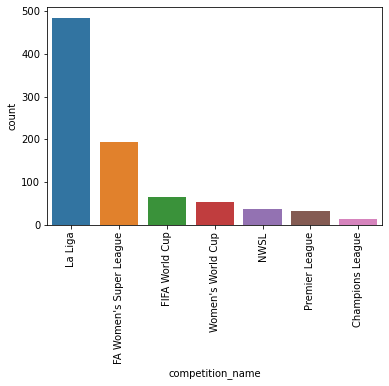

La Liga                    0.55
FA Women's Super League    0.22
FIFA World Cup             0.07
Women's World Cup          0.06
NWSL                       0.04
Premier League             0.04
Champions League           0.02
Name: competition_name, dtype: float64

In [9]:
### Match distribution by competition
sns.countplot(x='competition_name', 
              data=matches, 
              order = matches['competition_name'].value_counts().index)
plt.xticks(rotation=90)
plt.show()
round(matches['competition_name'].value_counts() / len(matches),2)

Looking into the seasons by competitions, this dataset contains matches 
for 16 seasons of the La Liga, 14 of the Champions League, 2 for the FA Women's Super League
and 1 season each for the reamining 4 leagues.

Yet a further exploration shows that despite the 14 Champion League seaons, only 1 match is covered in each season. The seasons best covered are actually the FA Women's Super League (107 and 87), the FIFA World Cup (64) and the Women's World Cup (52). Each of the La Liga seasons contain a range of 7 to 38 matches, and considering each La Liga season contains 380 matches (20 teams play each other twice)  [source: https://en.wikipedia.org/wiki/La_Liga], the best covered season contains only 10% of the season's matches. It is fair to say this dataset while still useful, is incomplete and caution should be exercised in interpretation.

In [10]:
### Match and season distribution by competition
matches.groupby(['competition_name'])['season_name'].nunique()
matches.groupby(['competition_name','season_name'])['match_id'].count()

competition_name
Champions League           14
FA Women's Super League     2
FIFA World Cup              1
La Liga                    16
NWSL                        1
Premier League              1
Women's World Cup           1
Name: season_name, dtype: int64

competition_name         season_name
Champions League         2003/2004        1
                         2004/2005        1
                         2006/2007        1
                         2008/2009        1
                         2009/2010        1
                         2010/2011        1
                         2011/2012        1
                         2012/2013        1
                         2013/2014        1
                         2014/2015        1
                         2015/2016        1
                         2016/2017        1
                         2017/2018        1
                         2018/2019        1
FA Women's Super League  2018/2019      107
                         2019/2020       87
FIFA World Cup           2018            64
La Liga                  2004/2005        7
                         2005/2006       17
                         2006/2007       26
                         2007/2008       28
                         2008/2009     

### Gender
Assuming there are no mix-gendered competitions, we extract the competition genders from the home team gender. 68% of our matches are for male competitions, largely made of the La Liga matches (55% of total matches), despite our 2 womens' competitions having the best covered seasons.

Also interesting to note is our dataset contains matches from 3 female competitions and 4 male competitions, thus in looking at the count of competitions the distribution seems even, but not at match level where 68% of the matches are from the 4 male competitions and the remaining 32% from the 3 female competitions.

In [11]:
### Competition by gender
matches.groupby(['match_gender','competition_name'])['match_id'].count()

match_gender  competition_name       
female        FA Women's Super League    194
              NWSL                        36
              Women's World Cup           52
male          Champions League            14
              FIFA World Cup              64
              La Liga                    485
              Premier League              33
Name: match_id, dtype: int64

<AxesSubplot:xlabel='match_gender', ylabel='count'>

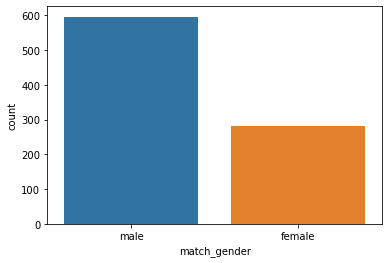

male      0.68
female    0.32
Name: match_gender, dtype: float64

In [12]:
### Matches by gender
sns.countplot(x='match_gender', data=matches)
plt.show()
round(matches['match_gender'].value_counts() / len(matches),2)

### Home-Away
In our dataset, the majority (47%) of matches are won by the home team, 37% are won by the away team and 16% are a tie.

<AxesSubplot:xlabel='win', ylabel='count'>

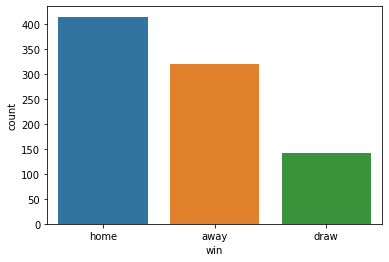

home    0.47
away    0.37
draw    0.16
Name: win, dtype: float64

In [13]:
### Match distribution won at home or away
sns.countplot(x='win', data=matches)
plt.show()
round(matches['win'].value_counts() / len(matches),2)

When we split the matches by gender, we see there is a slight difference in the distribution
of matches won at home, away and drawn. While both male and female gendered matches contain
more matches won at home than away, the distribution is less distinct in the female matches
than in the male matches. Because we know this dataset is incomplete, we cannot say that 
more male matches are won at home, this is only true for the limits of this dataset.

match_gender  win 
female        away    111
              draw     37
              home    134
male          away    210
              draw    105
              home    281
Name: match_id, dtype: int64

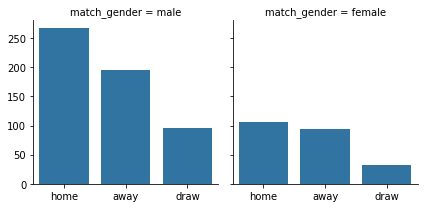

In [14]:
### Match distribution won at home or away by gender
g = sns.FacetGrid(matches, col="match_gender")
g.map_dataframe(sns.countplot, x="win")
matches.groupby(['match_gender','win'])['match_id'].count()

Looking at La Liga stats for 2017/2018 [source: https://www.soccerstats.com/latest.asp?league=spain_2018], for the full season Home wins were 47%, Away wins 30% and Draws 23%. Our sample of 36 matches for the same season is slightly unrepresentative at 49%, 35% and 16% respectively.

<AxesSubplot:xlabel='win', ylabel='count'>

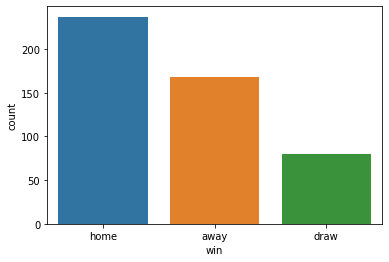

home    0.49
away    0.35
draw    0.16
Name: win, dtype: float64

'\n\n'

In [15]:
### Match distribution won at home or away for La Liga only
sns.countplot(x='win', data=matches[matches['competition_name']=='La Liga'])
plt.show()
round(matches[matches['competition_name']=='La Liga'].win.value_counts() / 
      len(matches[matches['competition_name']=='La Liga']),2)
'''

'''

In the chart below we see that generally the home-away win patterns are generally followed throughout all the competitions with the exception of the Champions League. This variation might be to do with the fact that unlike the other competitions using league tables, the Champions League has a knockout format, although it seems more plausible it is simply due to the sample as there is only 1 match per season for the Champions League in our dataset.

<Figure size 1296x432 with 0 Axes>

<AxesSubplot:xlabel='competition_name', ylabel='count'>

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'La Liga'),
  Text(1, 0, 'Champions League'),
  Text(2, 0, "Women's World Cup"),
  Text(3, 0, 'FIFA World Cup'),
  Text(4, 0, "FA Women's Super League"),
  Text(5, 0, 'NWSL'),
  Text(6, 0, 'Premier League')])

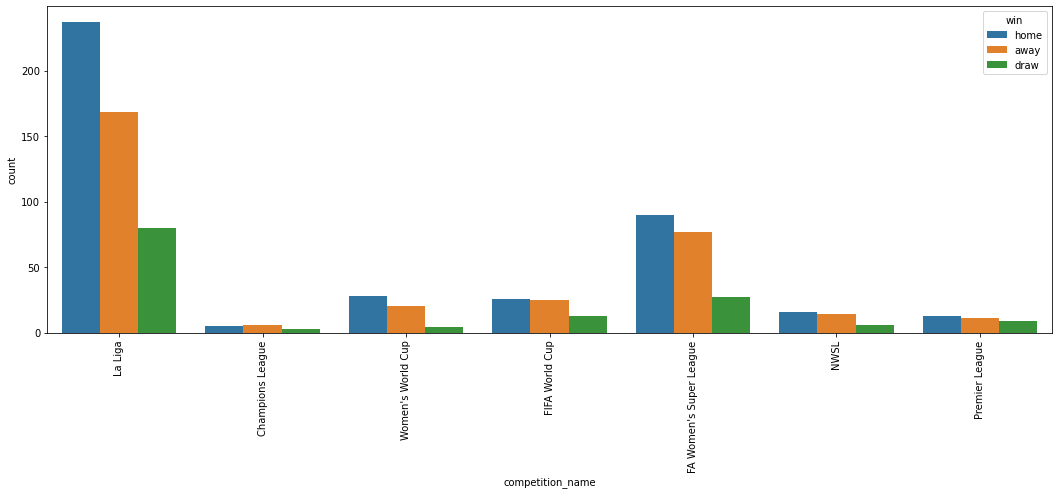

In [16]:
### Match distribution won at home or away across all competitions
plt.figure(figsize=(18,6))
sns.countplot(x='competition_name', data=matches, hue='win' )
plt.xticks(rotation=90)
#matches.groupby(['competition_name','win'])['match_id'].count()

<a id='analysis_team'></a>
# Analysis: Teams, Lineup & Manager

Because there is not a complete dataset, especially of a series, I have chosen not to consider player lineup or manager as a match winning feature. We would typically expect the football team and manager to remain consistent over a series (noting the starting lineup will change), and some analysis could have been made here to see if starting lineups, the use of a player, or the manager would have had any significant effect on match performance. However, as seen in the distribution of teams below, (i.e. the occurence of a team's match data as either a Home or Away team), there is a heavily skewed distribution of data in favour of the Barcelona team. Of 878 match data across all the competitions, Barcelona plays in 488 of them (56%).

It might not be farfetched to suggest the original creator of the dataset is a Barcelona fan. Yet, it could also be possible that Barcelona just have the most extensive collection of match data made accessible and available.

In [17]:
### Team distribution in dataset
teamdist = pd.Series()
teamdist = matches.apply(lambda x: extract(x['home_team'],'home_team_name'), axis=1)
teamdist = teamdist.append(matches.apply(lambda x: extract(x['away_team'],'away_team_name'), axis=1))
print('total matches: ',len(matches))
print('total teams: ', teamdist.nunique())
print('team matches:\n',teamdist.value_counts())

total matches:  878
total teams:  145
team matches:
 Barcelona                     488
Manchester City WFC            36
Arsenal WFC                    35
Brighton & Hove Albion WFC     35
Bristol City WFC               34
West Ham United LFC            34
Chelsea FCW                    34
Reading WFC                    34
Arsenal                        33
Liverpool WFC                  33
Everton LFC                    33
Birmingham City WFC            32
Real Madrid                    31
Atlético Madrid                30
Espanyol                       27
Valencia                       27
Sevilla                        27
Athletic Bilbao                25
Villarreal                     22
Getafe                         22
Real Sociedad                  21
Real Betis                     20
Yeovil Town LFC                19
Levante                        19
Manchester United              18
Osasuna                        18
Málaga                         17
Deportivo La Coruna          

/opt/anaconda3/envs/football/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


<a id='analysis_events'></a>
# Analysis: Events

Barring the use of lineup and manager data to build a model to predict a winning team, we look at match event data. This is a really extensive dataset and the limits of my personal computer meant I was not able to extract events data for all matches, I have thus limited event analysis to the first 100 matches ordered by match ID (~11% of total matches).

With this random sampling, by luck most of the distribution by competition is retained as shown in the table below showing match distribution for event data.

In [18]:
### Matches in reduced dataset by competition
eventdist = pd.DataFrame()
eventdist['count'] = events.groupby(['competition_name','match_id'])['id'].count()
eventdist = eventdist.reset_index()
events.groupby(['competition_name'])['match_id'].nunique()

competition_name
Champions League            1
FA Women's Super League    19
FIFA World Cup              8
La Liga                    55
NWSL                        5
Premier League              1
Women's World Cup           9
Name: match_id, dtype: int64

Next we look at the number of events recorded by competition to identify if there is some bias in the data.
In looking at the number of events recorded per match, we see there is some slight variation per competition (where we have >1 match per competition). In the boxplot below, La Liga matches appear to have more events recorded than the FA Women's Super League. In fact, the 3 female competitions appear to have fewer events recorded than the male competitions, although it is possibly arbitary as 2 of our 4 male competitions are only represented by a single match. Further analysis using the wider dataset would be needed to come to a significant conclusion.

<AxesSubplot:xlabel='competition_name', ylabel='count'>

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Champions League'),
  Text(1, 0, "FA Women's Super League"),
  Text(2, 0, 'FIFA World Cup'),
  Text(3, 0, 'La Liga'),
  Text(4, 0, 'NWSL'),
  Text(5, 0, 'Premier League'),
  Text(6, 0, "Women's World Cup")])

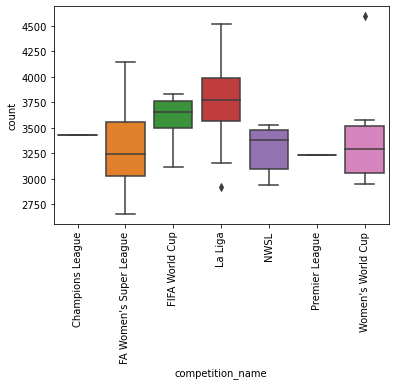

In [19]:
### Event distribution per match in reduced dataset by competition
sns.boxplot(x = 'competition_name', y='count', data=eventdist)
plt.xticks(rotation=90)
plt.show()

Looking deeper, La Liga matches have more events recorded and less variance than the FA Women's Super League (standard deviation of 311 and 414 respectively). This does indicate that not only do La Liga matches contain more events, they do so with greater consistency. Yet there could be multiple ways of interpreting this. Does this mean the La Liga is more "eventful" than the FA Women's Super League, or is it a reflection that La Liga matches are more carefully observed than the FA Women's Super League's matches?

In [20]:
### Event distribution per match in reduced dataset by competition
eventdist.describe()
eventdist.groupby(['competition_name'])['count'].describe()

,count
count,98.000000
mean,3612.061224
std,402.495279
min,2655.000000
25%,3364.750000
50%,3632.000000
75%,3903.750000
max,4598.000000


,count,mean,std,min,25%,50%,75%,max
competition_name,,,,,,,,
Champions League,1.0,3433.000000,NaN,3433.0,3433.00,3433.0,3433.0,3433.0
FA Women's Super League,19.0,3317.578947,414.407786,2655.0,3030.50,3247.0,3558.0,4143.0
FIFA World Cup,8.0,3591.875000,248.300186,3118.0,3500.25,3655.0,3768.0,3832.0
La Liga,55.0,3792.490909,311.654003,2916.0,3570.00,3776.0,3989.0,4525.0
NWSL,5.0,3284.400000,257.835800,2937.0,3092.00,3384.0,3478.0,3531.0
Premier League,1.0,3237.000000,NaN,3237.0,3237.00,3237.0,3237.0,3237.0
Women's World Cup,9.0,3392.666667,511.909904,2945.0,3055.00,3291.0,3521.0,4598.0


Looking at the distribution of event types in our dataset, we see in the chart below that passes and the ball being received are the two most populous events, which we would expect is normal in a game of football. 

The presence of a pass on its own is relatively meaningless, but the number of passes made by a winning/losing team in a match could be interesting. Another interesting feature to infer here would be the number of passes failed to be received by a winning or losing team, likely calculated as Passes - Ball Receipt. If given more time, I would have explored this.

<Figure size 1296x432 with 0 Axes>

<AxesSubplot:xlabel='type_name', ylabel='count'>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]),
 [Text(0, 0, 'Starting XI'),
  Text(1, 0, 'Half Start'),
  Text(2, 0, 'Pass'),
  Text(3, 0, 'Ball Receipt*'),
  Text(4, 0, 'Carry'),
  Text(5, 0, 'Pressure'),
  Text(6, 0, 'Miscontrol'),
  Text(7, 0, 'Ball Recovery'),
  Text(8, 0, 'Clearance'),
  Text(9, 0, 'Duel'),
  Text(10, 0, 'Foul Committed'),
  Text(11, 0, 'Dispossessed'),
  Text(12, 0, 'Dribbled Past'),
  Text(13, 0, 'Dribble'),
  Text(14, 0, 'Block'),
  Text(15, 0, 'Foul Won'),
  Text(16, 0, 'Goal Keeper'),
  Text(17, 0, 'Shot'),
  Text(18, 0, 'Interception'),
  Text(19, 0, '50/50'),
  Text(20, 0, 'Injury Stoppage'),
  Text(21, 0, 'Referee Ball-Drop'),
  Text(22, 0, 'Shield'),
  Text(23, 0, 'Player Off'),
  Text(24, 0, 'Player On'),
  Text(25, 0, 'Half End'),
  Text(26, 0, 'Offside'),
  Text(27, 0, 'Substitution'),
  Text(28, 0, 'Tactical Shift'),
  Text(29, 0, 'Ba

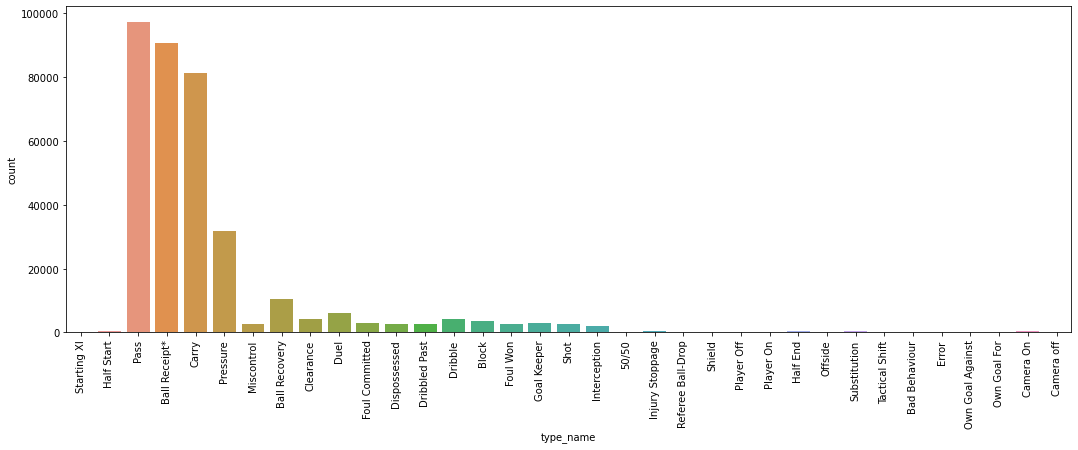

In [21]:
### Event type distribution in reduced dataset
plt.figure(figsize=(18,6))
sns.countplot(x='type_name', data=events)
plt.xticks(rotation=90)
plt.show()
#round(events['type_name'].value_counts() / len(events),2)


<a id='predictive_model'></a>
# Attempting a Predictive Model

Ideally, with more time I would have extracted more features from the events data and identified the best features to use. But for the purposes of demonstrating a built model I have picked some features, considerably at random, but largely influenced by an article [source: https://www.espn.co.uk/football/blog/name/93/post/2297787/headline] suggesting that a team's confidence in playing various formations is a critical factor in match performance. This led me to wonder if a team's starting formation might be indicative of success.

Along with starting formation, I also included if the team was playing at home (team_home = True) or not (team_home = False); and whether the match was played by males or females. 



In [22]:
### Extracting features from reduced dataset for predictive model
tactics = events[['team','tactics','type_name', 'home_team_id','match_gender','win_team_id']]
tactics = tactics[(tactics['tactics'].notnull()) & (tactics['type_name']=='Starting XI')]
tactics['formation'] = tactics.apply(lambda x: extract(x['tactics'],'formation'), axis=1)
tactics['team_id'] = tactics.apply(lambda x: extract(x['team'],'id'), axis=1)
tactics['team_home'] = tactics['team_id']==tactics['home_team_id']
tactics['team_won'] = tactics['team_id']==tactics['win_team_id']
tactics = tactics.drop(columns={'team','tactics','type_name','win_team_id','team_id','home_team_id'})

### One-hot encoding gender and formation
tactics = pd.concat([tactics.drop('match_gender', axis=1), pd.get_dummies(tactics['match_gender'])], axis=1)
tactics = pd.concat([tactics.drop('formation', axis=1), pd.get_dummies(tactics['formation'])], axis=1)
tactics

,team_home,team_won,female,male,343,352,433,442,451,3142,3412,3511,4141,4222,4231,4321,4411,41212,41221
0,True,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,False,False,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3561,True,False,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3562,False,True,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6584,True,True,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6585,False,False,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9944,True,False,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9945,False,True,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
13478,True,False,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
13479,False,True,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


With the preparation of our feature set, we see in the chart below that our dataset is generally balanced about 60-40 team losing and team winning. It is worth remembering our dataset has 100 matches, but the starting formations of both sides doubles the dataset to 200 as each match is represented by both the home and away team. One would expect then that team wins will equal team losses, but in the data preprocessing we considered only clear wins, and draws are in this case classified as a loss. Approximately 10 of our 100 matches have resulted in a draw, and in the case of our binary classifier, considered a loss.


<AxesSubplot:xlabel='team_won', ylabel='count'>

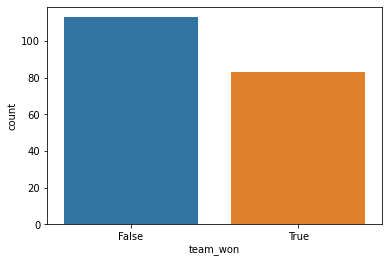

In [23]:
### Distribution of target class
sns.countplot(x='team_won', data=tactics)
plt.show()

LogisticRegression()

Logreg accuracy:  52.307692307692314


GradientBoostingClassifier()

GBC accuracy:  58.46153846153847


DecisionTreeClassifier()

DT accuracy:  55.38461538461539


RandomForestClassifier(random_state=0)

RF accuracy:  55.38461538461539


<AxesSubplot:>

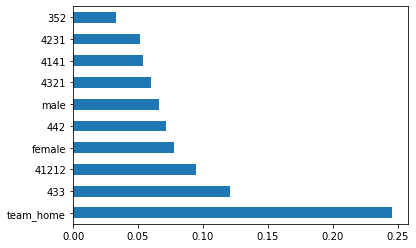

GaussianNB()

NB accuracy:  43.07692307692308


In [24]:
### Split train-test data
x = tactics.copy().drop(columns={'team_won'})
y = tactics['team_won']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
xy_train = list(zip(x_train, y_train))
xy_test = list(zip(x_test, y_test))

### Classifier models
dict_classifiers = {
    "Logreg": sklearn.linear_model.LogisticRegression(solver='lbfgs'),
    "GBC": sklearn.ensemble.GradientBoostingClassifier(),
    "DT": sklearn.tree.DecisionTreeClassifier(),
    "RF": sklearn.ensemble.RandomForestClassifier(max_depth=None, random_state=0),
    "NB": sklearn.naive_bayes.GaussianNB(),
}

for model, model_inst in dict_classifiers.items():
    model_inst.fit(x_train, y_train)
    pred = np.array(model_inst.predict(x_test))
    print(model, "accuracy: ",metrics.accuracy_score(y_test, pred)*100)
    #print(metrics.classification_report(y_test, pred, digits=3))
    if model == 'RF':
        feat_importances = pd.Series(model_inst.feature_importances_, index=x.columns)
        feat_importances.nlargest(10).plot(kind='barh')
        plt.show()
    
   

Generally, none of the models have performed extraordinarily well, the best accuracy achieved is 55% for the Decision Tree and Random Forest models. This will likely be due to the relevance of the features selected for this exercise. In the bar chart above (feature importance from the Random Forest model), we see that whether the team is playing at home or away is the most prominent feature, which does align with the home-away analysis earlier in this report.

The heatmap below demonstrates that all the features have weak correlations with each other, save for the exception of Male/Female which we know to be exclusive. Perhaps the most interesting insight from the correlation map is that male more than female matches favour a 433 formation. But at 0.23 that is not a strong correlation.  

<Figure size 1440x1440 with 0 Axes>

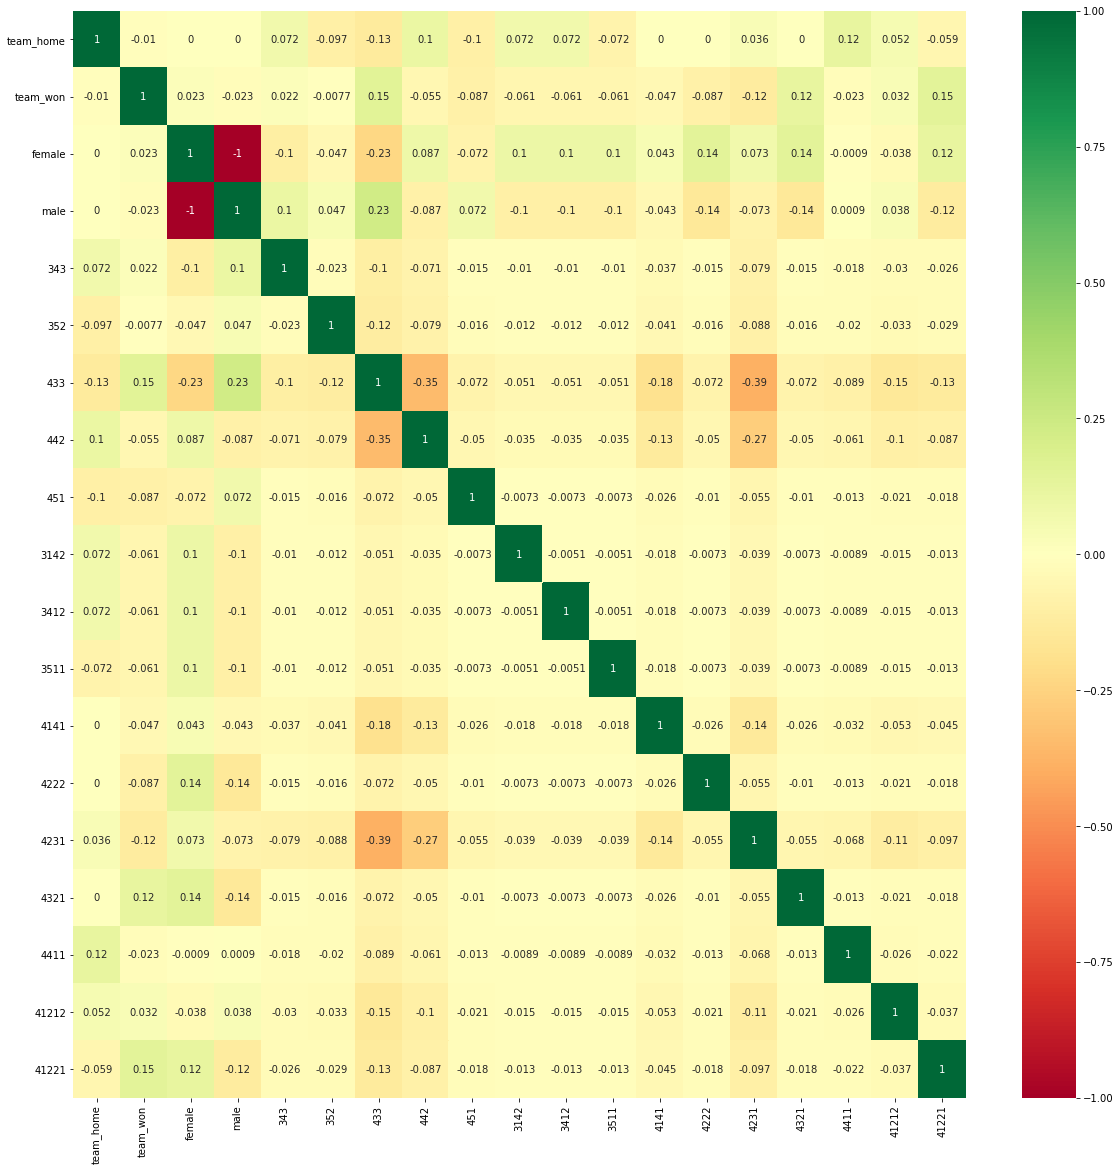

In [25]:
### Correlations of features
corrmat = tactics.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(tactics[top_corr_features].corr(),annot=True,cmap="RdYlGn")

<a id='conclusion'></a>
# Conclusion

Overall from this dataset we find that although the data covers 7 competitions, 4 male competitions and 3 female competitions, the proportion of matches are 68% male and 32% female. We find that none of the competitions' data is complete for any season, but the best covered season is that beloning to the FA Women's Super League 2018/2019 and 2019/2020 seasons. Yet the competition with the most number of seasons and matches included in this dataset is the La Liga. The Barcelona football team is the most prominent team and appears in 56% of the matches in this dataset as either a home or away team.

In looking at factors which impact a win, matches are most likely to be won at home games, and this appears to be consistent across competitions, seasons and genders. We did build a model to attempt to predict match wins, but the results are affected by a rather poor feature set. More time would have allowed a deeper exploration into the rich match events data, possibly identifying better features there. Although it was also noted that match events tended to be observed more in male competitions than female competitions, and thus if using event data as a predictor of match wins, this should be taken into consideration.